# Developing an AI application

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

I break down the project into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

The final product is an application that can be trained on any set of labeled images. Here my network will be learning about flowers and end up as a command line application. Further applications are up to our imagination. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. The possibilities are endless.

I completed this project as a part of the Udacity Data Scientist Nanodegree program.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import numpy as np
import time
import helper
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from workspace_utils import active_session

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings('ignore')

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. The input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I won't use any scaling or rotation transformations, but I'll resize then crop the images to the appropriate size.

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Define dir paths
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Define your transforms for the training, validation, and testing sets

# Add random transforms in training set for better generalization
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(255), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_valid_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_valid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

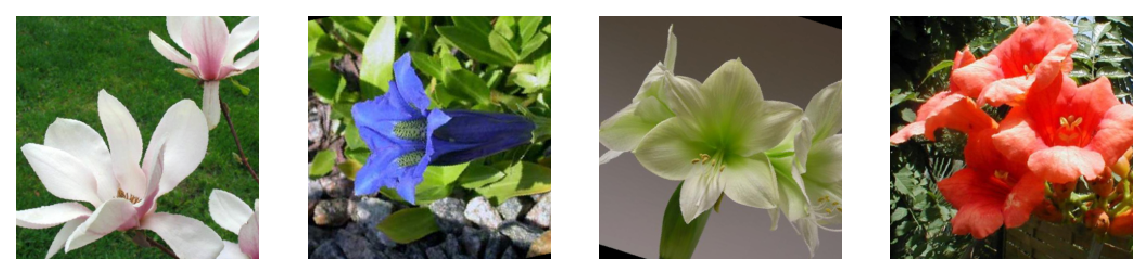

In [3]:
# Check images were loaded
images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)

### Label mapping

I load in a mapping from category label to category name. It is in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I use one of the pretrained models from `torchvision.models` to get the image features. I build and train a new feed-forward classifier using those features.


I implement the following:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (As a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

During training, I update only the weights of the feed-forward network. I try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. I save those hyperparameters to use as default values in the next part of the project.

In [5]:
# Define classifier class
class NN_Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Define validation function 
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
                
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [7]:
# Define NN function
def make_NN(n_hidden=[1024, 516], n_drop=0.5, n_epoch=2, labelsdict=cat_to_name, lr=0.001, \
            device='cuda', model_name='densenet169'):
    # Import pre-trained NN model 
    model = getattr(models, model_name)(pretrained=True)
    
    # Freeze parameters that we don't need to re-train 
    for param in model.parameters():
        param.requires_grad = False
        
    # Make classifier
    n_in = next(model.classifier.modules()).in_features
    n_out = len(labelsdict) 
    model.classifier = NN_Classifier(input_size=n_in, output_size=n_out, hidden_layers=n_hidden, drop_p=n_drop)
    
    # Define criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr = lr)

    model.to(device)
    start = time.time()

    epochs = n_epoch
    steps = 0 
    running_loss = 0
    print_every = 40
    for e in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            steps += 1

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{} - ".format(e+1, epochs),
                      "Training Loss: {:.3f} - ".format(running_loss/print_every),
                      "Validation Loss: {:.3f} - ".format(test_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))

                running_loss = 0

                # Make sure training is back on
                model.train()
    
    # Add model info 
    model.classifier.n_in = n_in
    model.classifier.n_hidden = n_hidden
    model.classifier.n_out = n_out
    model.classifier.labelsdict = labelsdict
    model.classifier.lr = lr
    model.classifier.optimizer_state_dict = optimizer.state_dict
    model.classifier.model_name = model_name
    model.classifier.class_to_idx = train_data.class_to_idx
    
    print('model:', model_name, '- hidden layers:', n_hidden, '- epochs:', n_epoch, '- lr:', lr)
    print(f"Run time: {(time.time() - start)/60:.3f} min")
    return model

In [8]:
# Def model test function 
def test_model(model, testloader=testloader, device='cuda'):  
    model.to(device)
    model.eval()
    accuracy = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
                
        output = model.forward(images)
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    print('Testing Accuracy: {:.3f}'.format(accuracy/len(testloader)))

Train different classifiers

In [9]:
model_a = make_NN(n_epoch=1)

Epoch: 1/1 -  Training Loss: 4.430 -  Validation Loss: 3.998 -  Validation Accuracy: 0.148
Epoch: 1/1 -  Training Loss: 3.563 -  Validation Loss: 2.567 -  Validation Accuracy: 0.395
model: densenet169 - hidden layers: [1024, 516] - epochs: 1 - lr: 0.001
Run time: 2.595 min


In [10]:
model_b = make_NN(n_epoch=1, lr=0.01)

Epoch: 1/1 -  Training Loss: 4.981 -  Validation Loss: 4.410 -  Validation Accuracy: 0.066
Epoch: 1/1 -  Training Loss: 4.379 -  Validation Loss: 4.137 -  Validation Accuracy: 0.081
model: densenet169 - hidden layers: [1024, 516] - epochs: 1 - lr: 0.01
Run time: 2.582 min


In [11]:
model_c = make_NN(n_epoch=2)

Epoch: 1/2 -  Training Loss: 4.442 -  Validation Loss: 4.025 -  Validation Accuracy: 0.175
Epoch: 1/2 -  Training Loss: 3.619 -  Validation Loss: 2.693 -  Validation Accuracy: 0.380
Epoch: 2/2 -  Training Loss: 2.494 -  Validation Loss: 1.650 -  Validation Accuracy: 0.639
Epoch: 2/2 -  Training Loss: 1.811 -  Validation Loss: 1.046 -  Validation Accuracy: 0.769
Epoch: 2/2 -  Training Loss: 1.478 -  Validation Loss: 0.853 -  Validation Accuracy: 0.782
model: densenet169 - hidden layers: [1024, 516] - epochs: 2 - lr: 0.001
Run time: 5.429 min


In [12]:
model_d = make_NN(n_epoch=3)

Epoch: 1/3 -  Training Loss: 4.450 -  Validation Loss: 4.043 -  Validation Accuracy: 0.238
Epoch: 1/3 -  Training Loss: 3.585 -  Validation Loss: 2.568 -  Validation Accuracy: 0.444
Epoch: 2/3 -  Training Loss: 2.455 -  Validation Loss: 1.568 -  Validation Accuracy: 0.620
Epoch: 2/3 -  Training Loss: 1.811 -  Validation Loss: 1.077 -  Validation Accuracy: 0.727
Epoch: 2/3 -  Training Loss: 1.437 -  Validation Loss: 0.828 -  Validation Accuracy: 0.786
Epoch: 3/3 -  Training Loss: 1.199 -  Validation Loss: 0.672 -  Validation Accuracy: 0.824
Epoch: 3/3 -  Training Loss: 1.068 -  Validation Loss: 0.590 -  Validation Accuracy: 0.857
model: densenet169 - hidden layers: [1024, 516] - epochs: 3 - lr: 0.001
Run time: 8.022 min


Model d was the best model!

## Testing your network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This gives us a good estimate for the model's performance on completely new images. I run the test images through the network and measure the accuracy, the same way I did with validation. 

In [14]:
# Do validation on the test set
test_model(model_d)

Testing Accuracy: 0.852


## Save the checkpoint

Now that the network is trained, I save the model so I can load it later for making predictions. I also save other things such as the mapping of classes to indices which I get from one of the image datasets: `image_datasets['train'].class_to_idx`. I attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

I will rebuild the model later to use it for inference. I include any information needed in the checkpoint. To load the model and keep training, I'll save the number of epochs as well as the optimizer state, `optimizer.state_dict`. I'll use this trained model in the next part of the project, so best to save it now.

In [16]:
# Get mapping of classes to indexes
model_d.class_to_idx = train_data.class_to_idx

# Save the checkpoint 

# Define function to save checkpoint
def save_checkpoint(model, path='modelcheckpoint.pth'):
    checkpoint = {'c_input': model.classifier.n_in,
                  'c_hidden': model.classifier.n_hidden,
                  'c_out': model.classifier.n_out,
                  'labelsdict': model.classifier.labelsdict,
                  'c_lr': model.classifier.lr,
                  'state_dict': model.state_dict(),
                  'c_state_dict': model.classifier.state_dict(),
                  'opti_state_dict': model.classifier.optimizer_state_dict,
                  'model_name': model.classifier.model_name,
                  'class_to_idx': model.class_to_idx
                  }
    torch.save(checkpoint, path)

In [17]:
save_checkpoint(model_d)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [9]:
# Make function that loads a checkpoint and rebuilds the model

def load_model(path):
    cp = torch.load(path)
    
    # Import pre-trained NN model 
    model = getattr(models, cp['model_name'])(pretrained=True)
    
    # Freeze parameters that we don't need to re-train 
    for param in model.parameters():
        param.requires_grad = False
    
    # Make classifier
    model.classifier = NN_Classifier(input_size=cp['c_input'], output_size=cp['c_out'], \
                                     hidden_layers=cp['c_hidden'])
    
    # Add model info 
    model.classifier.n_in = cp['c_input']
    model.classifier.n_hidden = cp['c_hidden']
    model.classifier.n_out = cp['c_out']
    model.classifier.labelsdict = cp['labelsdict']
    model.classifier.lr = cp['c_lr']
    model.classifier.optimizer_state_dict = cp['opti_state_dict']
    model.classifier.model_name = cp['model_name']
    model.classifier.class_to_idx = cp['class_to_idx']
    model.load_state_dict(cp['state_dict'])
    
    return model

In [10]:
# Load model
model_cp = load_model('modelcheckpoint.pth')

# Test loaded model
test_model(model_cp)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:06<00:00, 8652098.75it/s] 


Testing Accuracy: 0.852


# Inference for classification

Now I write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. I write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

## Image Preprocessing

I use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

First, I resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model
    '''
    # Process a PIL image for use in a PyTorch model
    # Resize and crop image
    im = Image.open(image)
    
    preprocess = transforms.Compose([transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
    
    im_tensor = preprocess(im)
    im_tensor.unsqueeze_(0)
    
    return im_tensor

The function below converts a PyTorch tensor and displays it in the notebook. Running the output of the `process_image` function through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

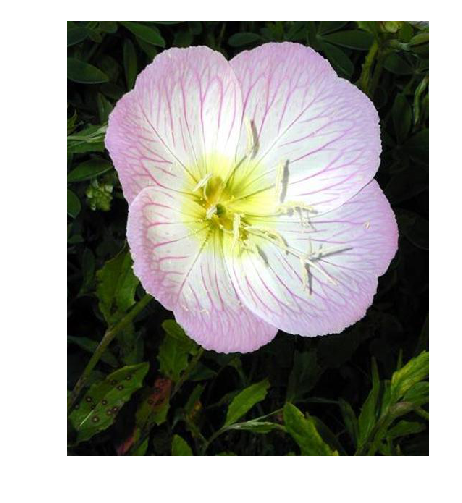

In [21]:
# Check reading image
import matplotlib.image as mpimg
im_path = 'flowers/test/class_001/image_06743.jpg'
img = mpimg.imread(im_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

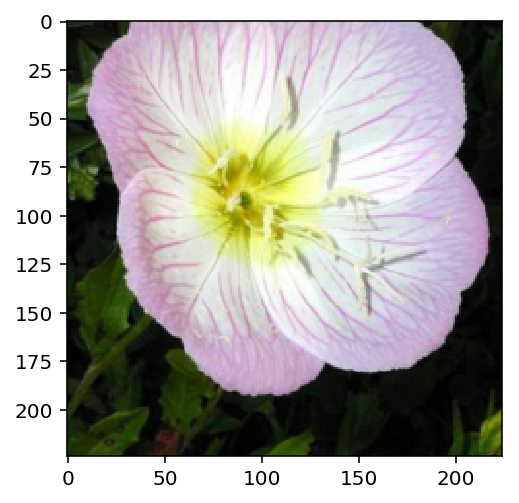

In [97]:
imshow(process_image(im_path).numpy()[0])

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. Here I calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I then convert from these indices to the actual class labels using `class_to_idx` which I added to the model or from an `ImageFolder` used to load the data ([see here](#Save-the-checkpoint)). I invert the dictionary to a mapping from index to class as well.


In [84]:
def predict(image_path, model, topk=5, device='cuda'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(device)
    model.eval()
    
    # Implement the code to predict the class from an image file
    img = process_image(image_path)
    img = img.to(device)
    
    output = model.forward(img)
    ps = torch.exp(output)    
    probs, idxs = ps.topk(topk)

    idx_to_class = dict((v,k) for k, v in model_cp.classifier.class_to_idx.items())
    classes = [v for k, v in idx_to_class.items() if k in idxs.to('cpu').numpy()]
    
    return probs.data.cpu().numpy()[0].tolist(), classes

In [85]:
probs, classes = predict(im_path, model_cp)
print(probs)
print(classes)

[0.8942073583602905, 0.04763377085328102, 0.03145592287182808, 0.004549773409962654, 0.004306602291762829]
['class_001', 'class_051', 'class_064', 'class_083', 'class_086']


## Sanity Checking

Now that the trained model can make predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, I use the `imshow` function defined above.

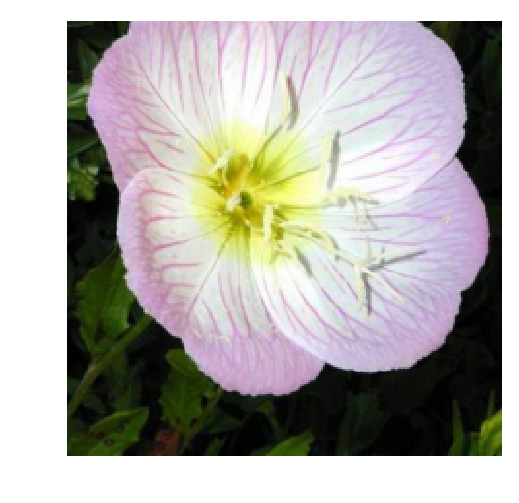

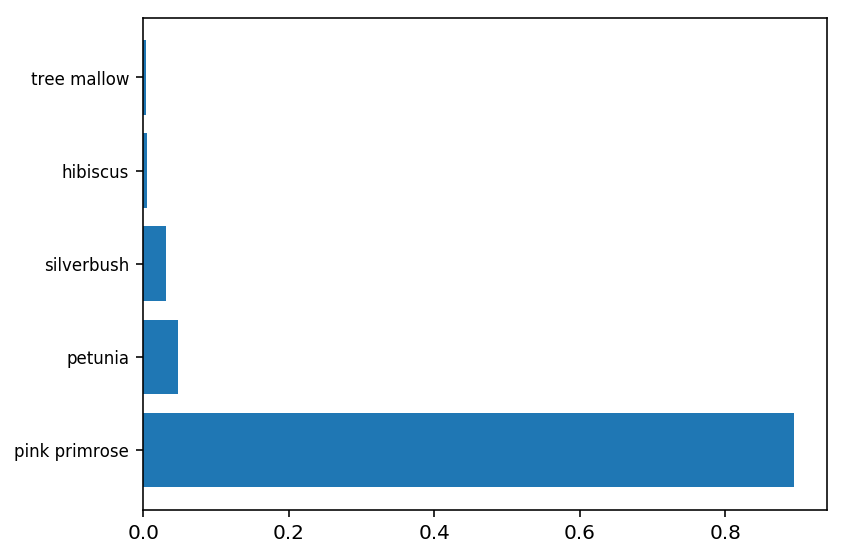

In [129]:
imshow(process_image(im_path).numpy()[0])
plt.axis('off')

fig, ax = plt.subplots()
ax.barh(np.arange(5), probs)
ax.set_yticks(np.arange(5))
ax.set_yticklabels([model_cp.classifier.labelsdict[str(i + 1)] for c, i in \
                     model_cp.classifier.class_to_idx.items() if c in classes], size='small');
plt.tight_layout()